In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.utils.multiclass import unique_labels

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [2]:
def printTree(feature_cols,tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('magic_tree.png')
    Image(graph.create_png())

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [47]:
def printMetrics(Yt, Yp, classes, model, norm=True, features=None):
    # Metrics
    plot_confusion_matrix(Yt, Yp, classes, normalize=norm)
    
    print("")
    print("Accuracy:",metrics.accuracy_score(Yt, Yp))
    print("Balanced Accuracy: ", metrics.balanced_accuracy_score(Yt, Yp))
    print("Precision: ", metrics.precision_score(Yt, Yp))
    print("Recall: ", metrics.recall_score(Yt, Yp))
    print("F1 Score: ",metrics.f1_score(Yt, Yp))
    
    feature_imp = pd.Series(model.feature_importances_,index=features).sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(feature_imp.index,feature_imp.values, align='center')
    #ax.set_yticks(pos, feature_imp.index)
    ax.set_xlabel('Performance')
    ax.set_title('How fast do you want to go today?')
    plt.grid(True)
    
    #print(feature_imp)
    
    plt.show()

In [48]:
features_in = "data/features_div_srl.csv"   
features = pd.read_csv(features_in, sep='\t')
features = features.fillna(0)
features.isnull().sum().sum()

0

In [49]:
feature_cols = [
        'duration',
        #'show_order',
        'fix_freq','sacc_freq','sr_fix_freq','sr_sacc_freq',
        'pupil_diam_right_mean','pupil_diam_right_std','pupil_diam_right_min','pupil_diam_right_max',
        'pupil_diam_left_mean','pupil_diam_left_std','pupil_diam_left_min','pupil_diam_left_max',
        'sr_pupil_diam_right_mean','sr_pupil_diam_right_std','sr_pupil_diam_right_min','sr_pupil_diam_right_max',
        'sr_pupil_diam_left_mean','sr_pupil_diam_left_std','sr_pupil_diam_left_min','sr_pupil_diam_left_max'
    ]

X = features[feature_cols]
Y = features['label']

In [50]:
# Oversample the 1 class to rebalance the dataset
X_resampled, y_resampled = SMOTE().fit_resample(X, Y)
X_train, X_test, y_train, y_test = \
        train_test_split(X_resampled, y_resampled,
                         train_size=0.75,test_size=0.25, random_state=1, shuffle=True) # 70% training and 30% test

Confusion matrix, without normalization
[[17  7]
 [ 7 12]]

Accuracy: 0.6744186046511628
Balanced Accuracy:  0.6699561403508771
Precision:  0.631578947368421
Recall:  0.631578947368421
F1 Score:  0.631578947368421


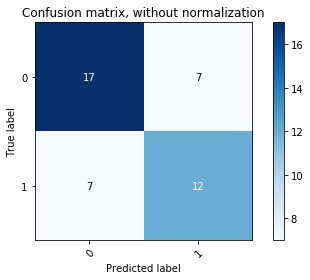

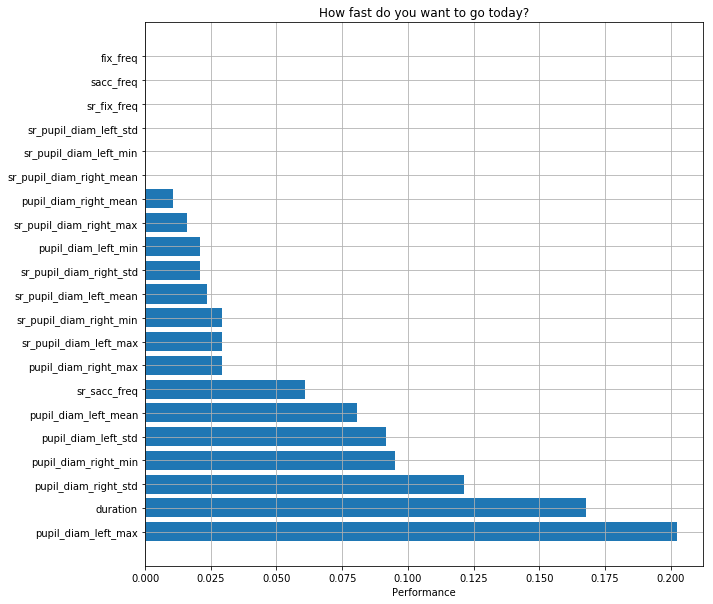

In [51]:
# Create Decision Tree classifer object
tree = DecisionTreeClassifier()

# Train Decision Tree Classifer
tree = tree.fit(X_train,y_train)

#Predict the response for test dataset
yt_pred = tree.predict(X_test)

#printTree(feature_cols, tree)
printMetrics(y_test, yt_pred, [0,1], tree, norm=False, features=feature_cols)
printTree(feature_cols, tree)

Confusion matrix, without normalization
[[14 10]
 [ 2 17]]

Accuracy: 0.7209302325581395
Balanced Accuracy:  0.7390350877192983
Precision:  0.6296296296296297
Recall:  0.8947368421052632
F1 Score:  0.7391304347826088


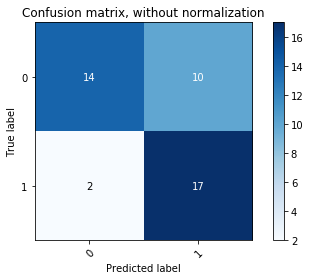

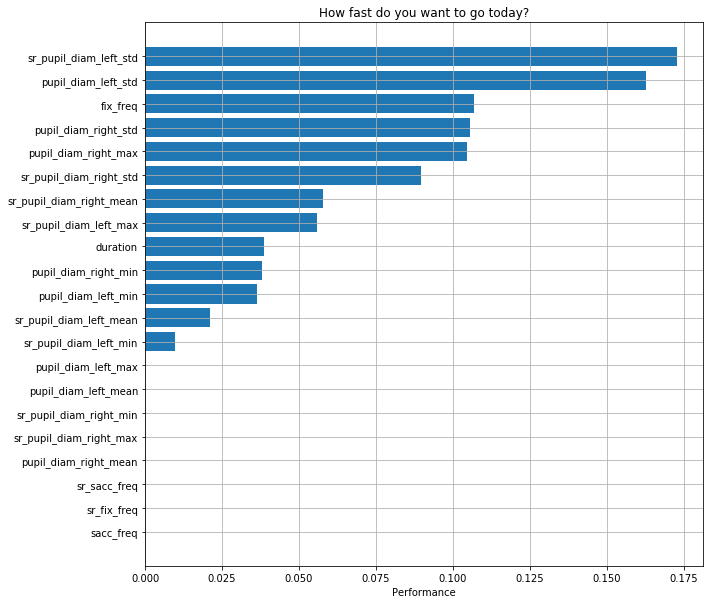

In [41]:
forest=RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train)
yf_pred=forest.predict(X_test)
printMetrics(y_test, yf_pred, [0,1], tree, norm=False, features=feature_cols)